In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pystan
import pickle
import h5py
from six import string_types
import phasekick
import pmefm
import lockin
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import stats
from tqdm import tqdm
from scipy import signal
import sigutils
from sigutils import log_bins
from scipy.signal.signaltools import _centered, _next_regular


NameError: name 'find_clo' is not defined

In [ ]:
fh = h5py.File('../data/tr-efm/151218-003450-100sun-784.h5', 'r')

In [ ]:
tp = fh['tp tip [s]'][0]

In [ ]:
psd_pulse = []
psd_voltage = []
for gr in tqdm(fh['data'].values()):
    t = phasekick.gr2t(gr)
    m = phasekick.masklh(t, 0, tp)
    m_voltage = phasekick.masklh(t, -50e-3, 0)
    x_pulse = gr['cantilever-nm'][:][m]
    x_non_pulse = gr['cantilever-nm'][:][m_voltage]
    f_pulse, _psd_pulse = signal.periodogram(x_pulse, nfft=_next_regular(x_pulse.size), window='blackman', fs=1e6)
    f_voltage, _psd_voltage = signal.periodogram(x_non_pulse,  nfft=_next_regular(x_non_pulse.size), window='blackman', fs=1e6)
    psd_pulse.append(_psd_pulse)
    psd_voltage.append(_psd_voltage)

psd_pulse = np.mean(np.array(psd_pulse), axis=0)
psd_voltage = np.mean(np.array(psd_voltage), axis=0)

In [ ]:
fc = f_voltage[np.argmax(psd_voltage)]

In [ ]:
plt.figure(figsize=(6.5, 3))
plt.rc('font', size=10)
plt.loglog(f_voltage, psd_voltage, alpha=0.75)
plt.loglog(f_pulse, psd_pulse, linewidth=1.5)
# cantilever_harmonics = [find_closest(f_voltage, fc*i) for i in xrange(1, 5)]
for i in xrange(1, 8):
    plt.axvline(fc*i, color='0', alpha=1, linestyle=':')
plt.axvspan(fc*6.2, fc*6.32, color='y', alpha=0.5, zorder=0)
plt.ylim(1e-8, 1e-3)
plt.xlim(5e4, 5.05e5)
plt.ylabel(u"PSD $P_{x}$ [nm²/Hz]")
plt.xlabel(u"Frequency $f$ [Hz]")
plt.text(5.2e4, 7.5e-8, 'before light pulse', color='b', bbox=dict(color='1', alpha=0.5))
plt.text(5.2e4, 2.5e-8, 'during light pulse', color='g', bbox=dict(color='1', alpha=0.5))
plt.tight_layout()
# plt.savefig('SI-PSD-x.pdf', bbox_inches='tight')

In [ ]:
fhpk = h5py.File('../data/pk-EFM/151218-012858-20sun-phasekick-768.h5', 'r')

In [20]:
ds0 = fhpk['data'].values()[fhpk['index'][:][0:1]]

/Users/ryandwyer/anaconda/envs/1605-phasekick/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


In [40]:
li = phasekick.gr2lock(ds0)
mL = phasekick.masklh(li.t, -100, li.tp)
mR = phasekick.masklh(li.t, li.tp, li.tp+0.002)
xL = li.x[mL]
xR = li.x[mR]

In [41]:
fL, psdL = signal.periodogram(xL, li.fs, 'blackman')
fR, psdR = signal.periodogram(xR, li.fs, 'blackman')

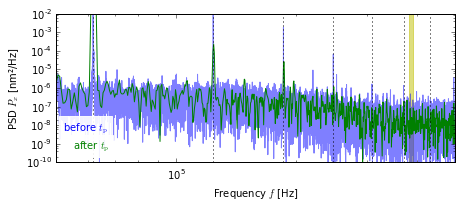

In [56]:
plt.figure(figsize=(6.5, 3))
plt.loglog(fL, psdL, '-', alpha=0.5)
plt.loglog(fR, psdR, '-', markeredgewidth=0)
for i in xrange(1, 8):
    plt.axvline(fc*i, color='0', alpha=1, linestyle=':')

plt.axvspan(fc*6.2, fc*6.32, color='y', alpha=0.5, zorder=0)
plt.ylabel(u"PSD $P_{x}$ [nm²/Hz]")
plt.xlabel(u"Frequency $f$ [Hz]")
plt.xlim(5e4, 5e5)
plt.ylim(1e-10, 1e-2)
plt.text(5.2e4, 5.5e-9, 'before $t_\\mathrm{p}$', color='b', bbox=dict(color='1', alpha=0.9))
plt.text(5.5e4, 5.5e-10, 'after $t_\\mathrm{p}$', color='g', bbox=dict(color='1', alpha=0.9))
plt.tight_layout()
plt.savefig('../figs/SI-201-PSD-pk-EFM.pdf', bbox_inches='tight')